### How Art and Language are tied together?
This is a vert quick and simple experiment to see how [Artsy's](artsy.net) ['art genes'](https://www.artsy.net/categories) just based on the textual description of the genes.

##### Background
Structuralists and Post-Structuralist beleive language and arts are both sign systems. In Hermeneutics, an 'artwork', similar to a 'word' gets its meaning through human interpretation. Nietzsche along with Deleuze and Guattari, believed language and art are mechanism of creating new concepts and ways of being. But aside from these theories, we know an artwork is such a fluid entity that by describing and interpreting it, becomes something different. It is interesting to investigate how the description of artworks are related to each other regardless of the artwork itself as an object to verify if the object 'becomes' its description.

##### Method
1. Load pre-trained word2vec embeding vectors (trained from Wikipedia + News)
2. Create a vector for each gene description from Artsy's API by adding up the embeding vector of each word in the description
3. Compare/Visualize genes

##### Usecase
With a good embedimg model it is possible to get similarity neighborhood of a gene, or add and subtract them similar to this [Game of Thrones embeding](https://medium.com/towards-data-science/game-of-thrones-word-embeddings-does-r-l-j-part-1-8ca70a8f1fad). 

This is just a quick experiment. 


In [2]:
from gensim.models import Word2Vec

#model = Word2Vec().load_word2vec_format("./GoogleNews-vectors-negative300.bin", binary=True)
model = Word2Vec().load_word2vec_format("./glove.6B.300d.txt")

In [3]:
model.most_similar("art", topn=10)

[('arts', 0.7138696312904358),
 ('museum', 0.684175968170166),
 ('paintings', 0.650521993637085),
 ('painting', 0.6487808227539062),
 ('gallery', 0.6464606523513794),
 ('sculpture', 0.6448274850845337),
 ('photography', 0.6387885212898254),
 ('contemporary', 0.6316169500350952),
 ('exhibition', 0.6165661811828613),
 ('artist', 0.6034246683120728)]

In [4]:
model.most_similar_cosmul(positive=["painting", "programming"], topn=5)

[('works', 0.4912715256214142),
 ('art', 0.4907427430152893),
 ('paintings', 0.4817741811275482),
 ('abstract', 0.47614383697509766),
 ('arts', 0.4670995771884918)]

In [5]:
import json

with open('../genes.json') as data_file:    
    genes = json.load(data_file)

print(len(genes))

1031


In [6]:
for i, gene in enumerate(genes):
    if i==0:
        print(gene["name"])

"Bad Painting"


In [7]:
from nltk import pos_tag, word_tokenize
from gensim import matutils
import numpy as np


def build_category_vector(category, i): 
    words = word_tokenize(category)
    words=[word.lower() for word in words if word.isalpha()]
    postags = pos_tag(words)
    vector = []
    for tag in postags:
        if tag[1] in ['NN', 'NNS', 'JJ', 'NNP', 'NNPS', 'NNDBN', 'VBG', 'CD']:  # Only keep meaningful words
            try:
                v = model[tag[0]]  # Get the word vector
                if v.any():
                    vector.append(v)
            except:
                print("Word not found in corpus: %s" % tag[0])
            tagset.append(tag[0])
    
    #print(vector, len(vector))
    #print(matutils.unitvec(np.array(vector).mean(axis=0)))
    if vector and len(vector)>0:
        return matutils.unitvec(np.array(vector).mean(axis=0))  # Average the vector
    else:
        print('returning zeros for ', len(vector), i, category)
        return np.zeros(300)


gene_vectors = []
tagset = []

# print('printing')
# print(genes[477])
# a = build_category_vector(genes[477]["description"], 477)
# print(a)

gene_names = []
for i, gene in enumerate(genes):
    #if i==0:
        print(gene["name"])
        if gene["description"]:
            gene_vectors.append(build_category_vector(gene["description"] , i))
            gene_names.append(gene["name"])
        #print(len(gene_vectors))

"Bad Painting"
'85 New Wave
1000–1400 CE
15th Century
Word not found in corpus: macchu
16th Century
17th Century
18th Century
1900–1917
1918–1939 (Interwar)
1940s–1950s
1960s
1970s
Word not found in corpus: postminimalism
1980s
1990s
19th Century
19th Century American Art
Word not found in corpus: ossawa
19th Century American Paintings and Works on Paper
19th Century French Academy
Word not found in corpus: gardeuse
19th Century German Realism
2000–present
20th Century Art
20th Century Furniture and Design
500–1000 CE
Word not found in corpus: abassid
Aboriginal Art
Abstract Art
Abstract Expressionism
Abstract Illusionism
Abstract Landscape
Abstract Painting
Abstract Photography
Abstract Sculpture
Abstract versus Figurative Art
Abstraction-Création
Action Painting
Adolescence
Advertising and Brands
Aerial View
Africa
African Diaspora
Word not found in corpus: wangechi
Afrofuturism
Album, Folio and Fan Formats
Allegory
Allover Composition
Altarpiece
Word not found in corpus: isenheim
Al

Dau Al Set
De Stijl
Word not found in corpus: mdash
Word not found in corpus: mdash
Decay
Word not found in corpus: crystallizations
Word not found in corpus: jiangbo
Deconstructivism
Word not found in corpus: himelblau
Deep Time
Word not found in corpus: waterscapes
Deities and Holy Figures
Word not found in corpus: alinka
Delegated Art
Delicate Materials
Word not found in corpus: hoshimoto
Dense Composition
Word not found in corpus: wheatpaste
Densely Textured or Haptic Surface
Word not found in corpus: benjamim
Design
Design by Architects
Word not found in corpus: starchitects
Design by Artists
Design/Architecture Study
Desk
Deutscher Werkbund
Word not found in corpus: saarninen
Diaristic
Die Brücke
Word not found in corpus: bleyl
Digital Art
Digital Culture
Digital Painting and Drawing
Digital Print
Digital as Manual
Word not found in corpus: bayrle
Digitally Manipulated
Word not found in corpus: photopaint
Dining Table
Disaster
Divinatory Objects, Talismans, and Amulets
Divisionis

Metallic
Word not found in corpus: reyle
Mexican Muralism
Mexico
Middle Africa
Middle East
Migration
Mimicking Ruined Materials
Word not found in corpus: arsham
Ming Dynasty
Miniature and Small-Scale Paintings
Minimalism
Minimalism and Contemporary Minimalist
Minoan Art
Mirror
Mirrored
Mixed-Media
Moche Art
Modern
Modern Design
Modern Jewelry
Modern Photography
Word not found in corpus: sadakichi
Modern and Contemporary Design
Modern and Contemporary Fashion Design
Modern and Impressionist Art
Modern and Impressionist Prints
Modes of Transportation
Modular Design
Molecular
Mono-ha
Word not found in corpus: ufan
Monochrome Painting
Monotype/Monoprint
Word not found in corpus: monoprinting
Word not found in corpus: monotyping
Word not found in corpus: monotyping
Mortality
Mosaics
Mourning and Commemoration
Movement
Mughal Art
Multiple Exposure
Multiple Screens
Multiple Styles
Murals and Wall Drawings
Music
Musical Instrument
Mutated Bodies
Mycenaean Art
Mysticism, Shamanism, and the Occu

Word not found in corpus: mdash
Word not found in corpus: mdash
Sports/Athletics
Spray Paint
Word not found in corpus: jaybo
Staged Photography
Word not found in corpus: rejlander
Stained Glass
Stained Glass Effect
Word not found in corpus: cloisonnism
Stains/Washes
Word not found in corpus: gessoed
Steel
Steel/Iron Frame Construction
Still Life
Stolen Moments
Stone
Stool
Storage
Street Photography
Striped
Word not found in corpus: nonhierarchical
Study
Suburbia
Sui Dynasty
Suprematism
Surrealism
Surveillance
Word not found in corpus: paglen
Suspended/Hanging
Sustainable Design
Switzerland
Symbolic Composition
Symbolism
Symmetrical
Synchromism
Word not found in corpus: synchromist
Word not found in corpus: synchromist
Table
Table Lamp
Tablet/Stele
Tableware
Taiwan
Talismanic
Word not found in corpus: betye
Tang Dynasty
Tangled Forms
Tapestry and Wall Hanging
Word not found in corpus: anatsui
Taxidermy
Technology
Tempera
Word not found in corpus: cennino
Terracotta
Text
Textile Arts
Wor

In [8]:
for i, gene_vector in enumerate(gene_vectors):
    if np.isnan(np.sum(gene_vector)):
        print(i, genes[i]['name'], gene_vector)


from sklearn.decomposition import PCA

X = np.array(gene_vectors)
print(len(X))
pca = PCA(n_components=2)
pca.fit(X)
pca_transform = pca.transform(X)

print(pca.explained_variance_ratio_)

#477 #595 #818

910
[ 0.10667413  0.07649864]


In [9]:
import pandas as pd

pca_df = pd.DataFrame(pca_transform)

#gene_names = map(lambda x: x['name'], genes)

#print(gene_names)
pca_df.index = gene_names
pca_df.columns = ['PC1','PC2']

pca_df.head()



,PC1,PC2
"""Bad Painting""",-0.052761,-0.180551
'85 New Wave,0.188180,-0.062048
1000–1400 CE,0.167496,0.078040
15th Century,-0.037573,-0.051456
16th Century,0.139529,-0.085734


In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)

clusters =kmeans.fit(X)
#y_pred = kmeans.predict(X)

pca_df['cluster'] = pd.Series(clusters.labels_, index=pca_df.index)



In [11]:
pca_df.to_csv('genes_pca.csv')
pca_df.to_json('genes_pca.json')

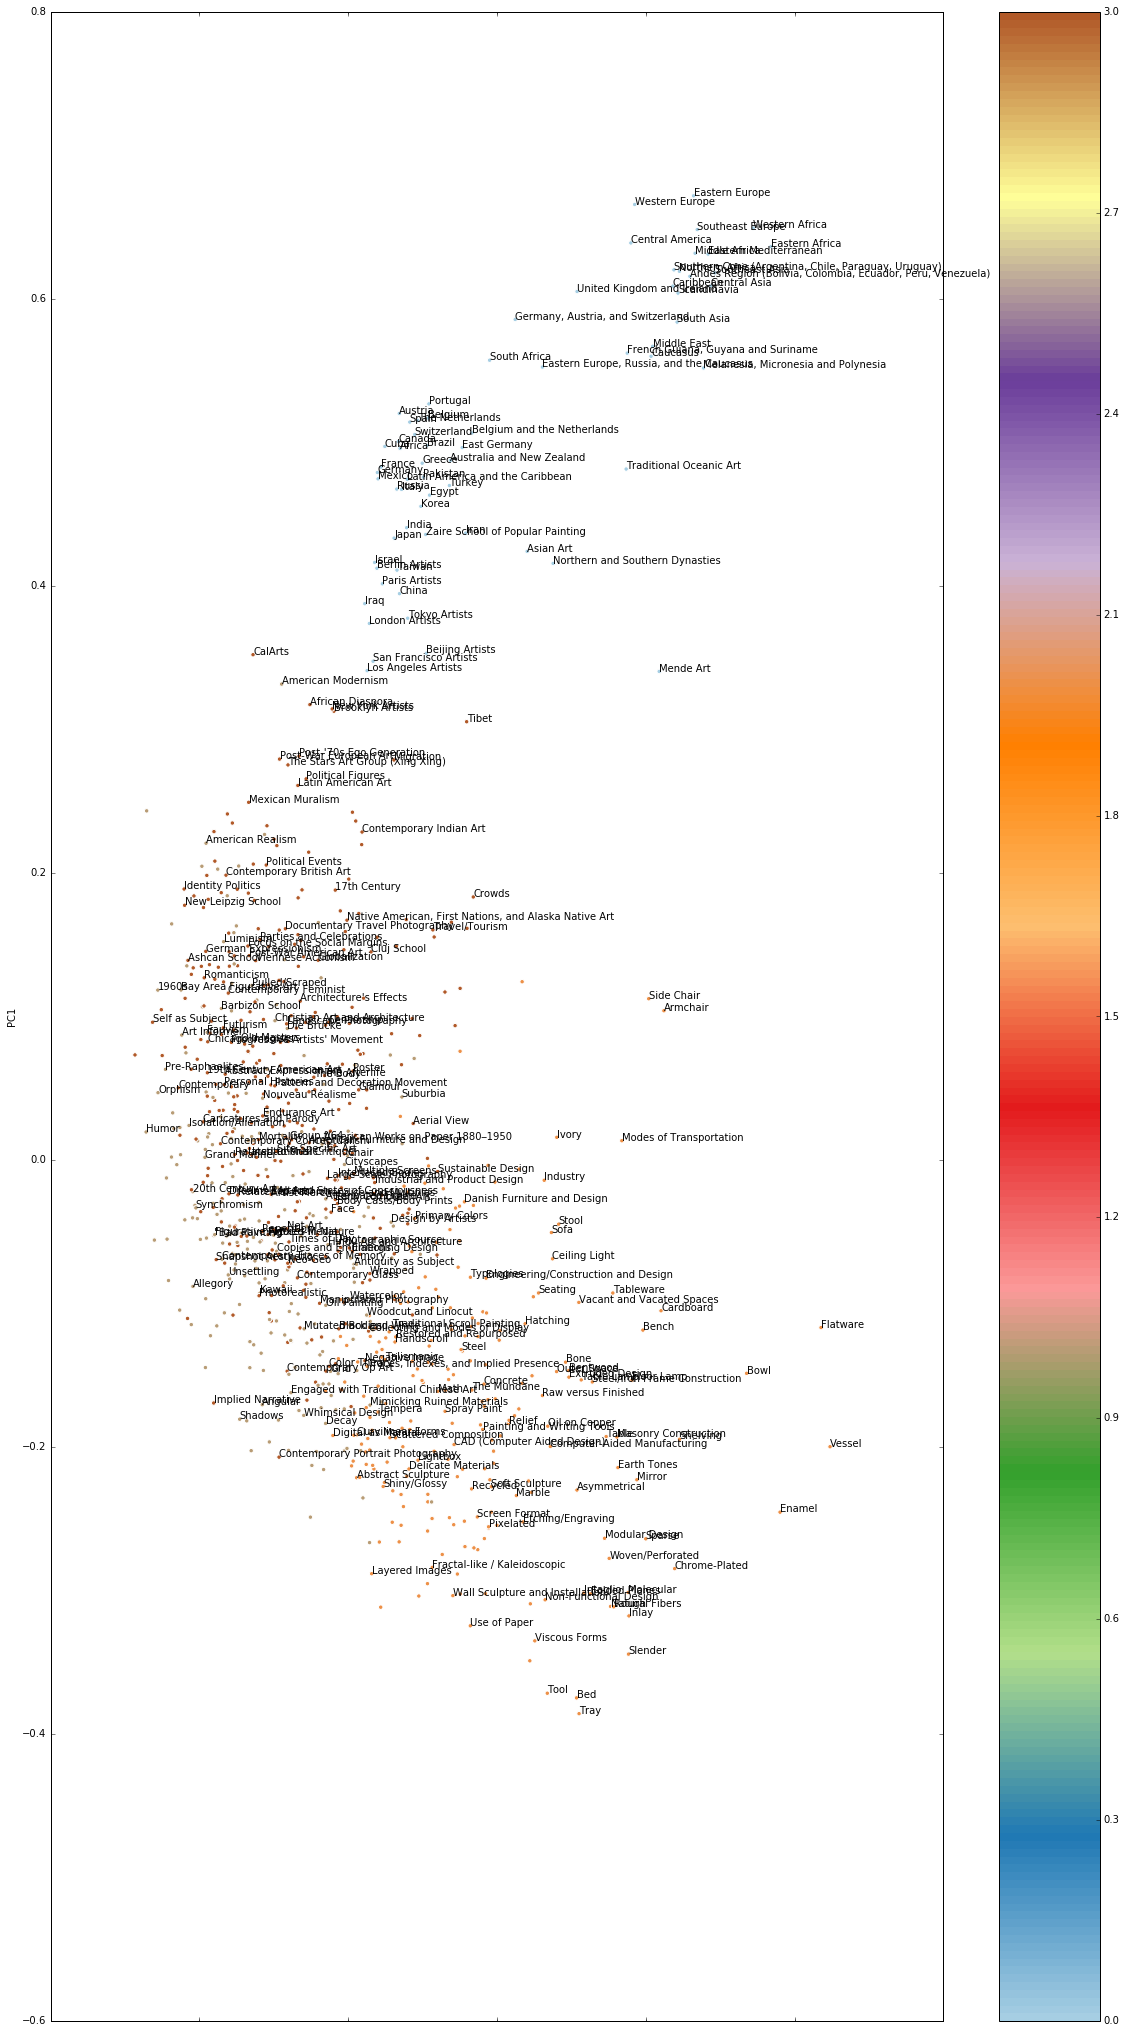

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = pca_df.plot(kind='scatter', x='PC2', y='PC1', edgecolor='w',  c=pca_df.cluster.astype(np.float), cmap=plt.cm.Paired,  figsize=(20,36))

for i, gene_name in enumerate(pca_df.index):
    if (pca_df.iloc[i].PC1 > 0.25 or pca_df.iloc[i].PC2 > 0.25 ) or i % 5 == 0:
        ax.annotate(gene_name, (pca_df.iloc[i].PC2, pca_df.iloc[i].PC1))